In [1]:
from util import *

import pandas as pd
import numpy as np 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from xgboost import plot_importance

In [2]:
df = pd.read_csv('preprocess_data.csv')
df

,title,year,rating,runtime,kind,color_info,sound_mix,director_name,genre,director_id,cast_names,cast_ids,votes,country,day,month
0,Miss Jerry,1894.0,5.9,40,movie,Black and White,Silent,['Alexander Black'],"['Short', 'Romance']",['0085156'],"['Blanche Bayliss', 'William Courtenay', 'Chau...","['0063086', '0183823', '1309758']",191,USA,0,8.0
1,The Story of the Kelly Gang,1906.0,6.1,70,movie,Black and White,Silent,['Charles Tait'],"['Action', 'Adventure', 'Biography', 'Crime', ...",['0846879'],"['Elizabeth Tait', 'John Tait', 'Nicholas Brie...","['0846887', '0846894', '1431224', '3002376', '...",737,Australia,26,12.0
2,Den sorte drøm,1911.0,5.9,53,movie,Black and White,Silent,['Urban Gad'],['Drama'],['0300487'],"['Asta Nielsen', 'Valdemar Psilander', 'Gunnar...","['0003425', '0699637', '0375839', '0016799', '...",218,Germany,19,8.0
3,Cleopatra,1963.0,7,192,movie,Color,DTS,['Joseph L. Mankiewicz'],"['Biography', 'Drama', 'History', 'Romance']",['0000581'],"['Elizabeth Taylor', 'Richard Burton', 'Rex Ha...","['0000072', '0000009', '0001322', '0114386', '...",31526,Canada,31,7.0
4,Torment,1994.0,7.1,102,movie,Color,Dolby,['Claude Chabrol'],"['Crime', 'Drama', 'Thriller']",['0001031'],"['Emmanuelle Béart', 'François Cluzet', 'Natha...","['0000322', '0167388', '0136597', '0932870', '...",4936,France,16,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85328,A Second Chance: Rivals!,2019.0,4.8,89,movie,Color,NaN,['Clay Glen'],"['Drama', 'Family', 'Sport']",['4825581'],"['Emily Morris', 'Stella Shute', 'Carmel Johns...","['4825006', '10195787', '0424718', '1138590', ...",338.0,Australia,24,10.0
85329,Feed,2017.0,6.2,95,movie,Color,NaN,['Tommy Bertelsen'],['Drama'],['0077879'],"['Troian Bellisario', 'Tom Felton', 'Ben Winch...","['0069079', '0271657', '3656718', '0001664', '...",2445.0,USA,18,7.0
85330,Capernaum,2018.0,8.4,126,movie,Color,Dolby,['Nadine Labaki'],['Drama'],['1701024'],"['Zain Al Rafeea', 'Yordanos Shiferaw', 'Boluw...","['9862858', '9862859', '9862860', '10201625', ...",78256.0,Lebanon,20,10.0
85331,G-Loc,2020.0,4.6,92,movie,Color,NaN,['Tom Paton'],['Sci-Fi'],['7441188'],"['Stephen Moyer', 'Tala Gouveia', 'John Rhys-D...","['0610459', '4823334', '0722636', '7478548', '...",1597.0,USA,11,8.0


In [3]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df= df[pd.to_numeric(df['rating'], errors='coerce').notnull()]

In [4]:
df['year'].value_counts()

2018.0    3362
2017.0    3269
2016.0    3069
2019.0    2976
2015.0    2930
          ... 
1911.0       3
1906.0       1
1902.0       1
1895.0       1
1894.0       1
Name: year, Length: 115, dtype: int64

# Feature Engineering


In [5]:
# age là tuổi của phim được cho đến năm hiện tại (2021)
df['age'] = 2021 - df['year']
df['age']

<ipython-input-5-e771d501488d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = 2021 - df['year']


0        127.0
1        115.0
2        110.0
3         58.0
4         27.0
         ...  
85328      2.0
85329      4.0
85330      3.0
85331      1.0
85332      2.0
Name: age, Length: 84985, dtype: float64

In [6]:
df = df.dropna(subset = ['cast_names','cast_ids','director_name','director_id'])

In [7]:
df['cast_ids']

0                        ['0063086', '0183823', '1309758']
1        ['0846887', '0846894', '1431224', '3002376', '...
2        ['0003425', '0699637', '0375839', '0016799', '...
3        ['0000072', '0000009', '0001322', '0114386', '...
4        ['0000322', '0167388', '0136597', '0932870', '...
                               ...                        
85328    ['4825006', '10195787', '0424718', '1138590', ...
85329    ['0069079', '0271657', '3656718', '0001664', '...
85330    ['9862858', '9862859', '9862860', '10201625', ...
85331    ['0610459', '4823334', '0722636', '7478548', '...
85332    ['0397034', '0001745', '9602953', '10509918', ...
Name: cast_ids, Length: 83100, dtype: object

In [8]:
# tách 1 chuỗi string thành mảng các string chứa thông tin
df['cast_names'] = df['cast_names'].apply(split_text)
df['cast_ids'] = df['cast_ids'].apply(split_text)
df['director_name'] = df['director_name'].apply(split_text)


In [9]:
#number cast là số lượng thành viên đoàn cast
df['number_cast'] = df['cast_names'].apply(lambda s: len(s))
df['number_cast']

0          3
1         17
2         11
3         85
4         27
        ... 
85328     22
85329     21
85330    115
85331     10
85332     28
Name: number_cast, Length: 83100, dtype: int64

In [10]:
le = preprocessing.LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df['kind'] = le.fit_transform(df['kind'])
df['color_info'] = le.fit_transform(df['color_info'])
df['sound_mix'] = le.fit_transform(df['sound_mix'])


In [11]:
df = df.reset_index(drop = True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 1)

In [13]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [14]:
# xây dựng dict chứa thông tin về điểm trung bình của đạo diễn và các diễn viên
# cast_score_board = getScoreBroad(X_train['cast_ids'], y_train)
# director_score_board = getScoreBroad(X_train['director_id'], y_train)

Xây dựng dict bằng tập train và sau đó mapping sang tập test

In [15]:
# for i in X_train.index:
#     s = df['cast_ids'][i]
#     me, ma, mi = getScore(s, cast_score_board)
#     X_train.loc[i,'cast_mean_score'] = me
#     X_train.loc[i,'cast_max_score'] = ma
#     X_train.loc[i,'cast_min_score'] = mi
    
#     s = df.loc[i,'director_id']
#     me, ma, mi = getScore(s, director_score_board)
#     X_train.loc[i,'director_mean_score'] = me
#     X_train.loc[i,'director_max_score'] = ma
#     X_train.loc[i,'director_min_score'] = mi

    
# for i in X_test.index:
#     s = df['cast_ids'][i]
#     me, ma, mi = getScore(s, cast_score_board)
#     X_test.loc[i,'cast_mean_score'] = me
#     X_test.loc[i,'cast_max_score'] = ma
#     X_test.loc[i,'cast_min_score'] = mi
    
#     s = df['director_id'][i]
#     me, ma, mi = getScore(s, director_score_board)
#     X_test.loc[i,'director_mean_score'] = me
#     X_test.loc[i,'director_max_score'] = ma
#     X_test.loc[i,'director_min_score'] = mi

# Visualize 


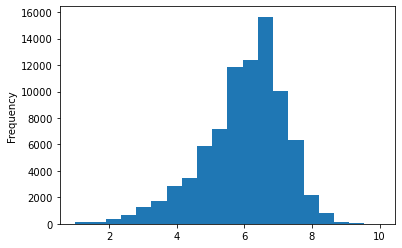

In [16]:
df.rating.plot.hist(bins = 20);

phân bố của rating tập trung chủ yếu ở 6 đến 7 điểm 

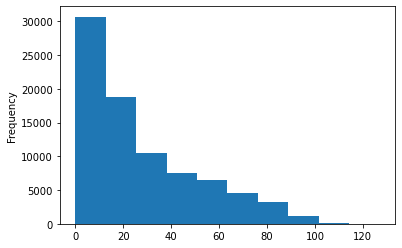

In [17]:
df.age.plot.hist();

Số lượng phim tập trung vào 20 năm đổ lại

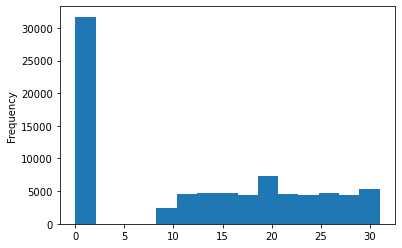

In [18]:
df.day.plot.hist(bins = 15);

Phim chủ yếu được release vào cuối tháng, tập trung chủ yếu vào ngày 19 đến 20

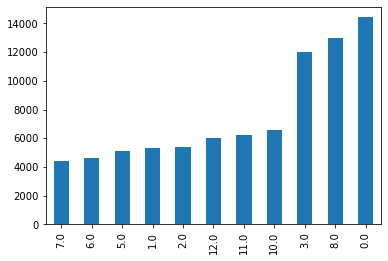

In [19]:
df.month.value_counts().sort_values().plot.bar(); 

Phim được phát hành tập trung vào các tháng đầu và cuối năm

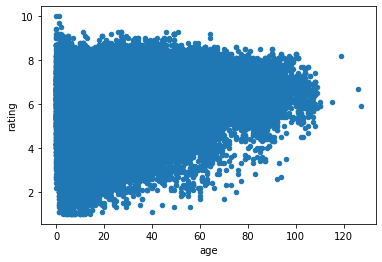

In [20]:
df.plot.scatter(x='age', y='rating');

Có thể dễ dàng thấy được số lượng phim có tuổi đời lớn hơn 70 có rating cao hơn và số lượng ít hơn.

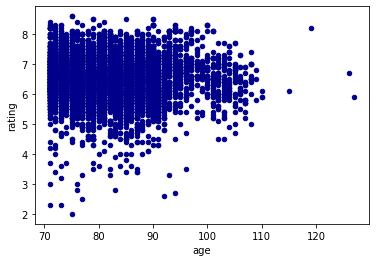

In [21]:
case = df[df['age']>70]
case.plot.scatter(x='age', y='rating', c='DarkBlue');

In [22]:
print('Rating trung bình của các bộ phim có tuổi đời lớn hơn 70:',round(case.rating.mean(),3))
print('Rating trung bình của tất cả phim:',round(df.rating.mean(),3))

Rating trung bình của các bộ phim có tuổi đời lớn hơn 70: 6.496
Rating trung bình của tất cả phim: 5.971


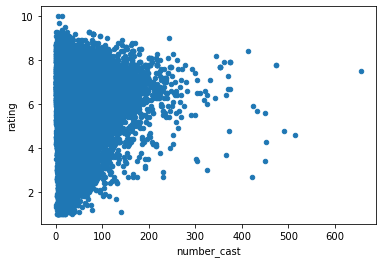

In [23]:
df.plot.scatter(x= 'number_cast', y='rating');

Với number cast lớn thì phim có xu hướng điểm cao hơn

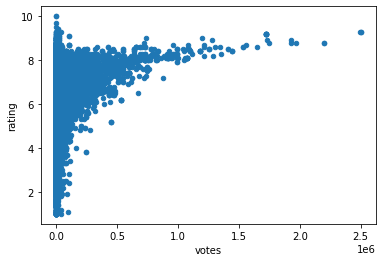

In [24]:
df.plot.scatter(x= 'votes', y='rating');

Số vote càng cao thì tỉ lệ rate càng cao

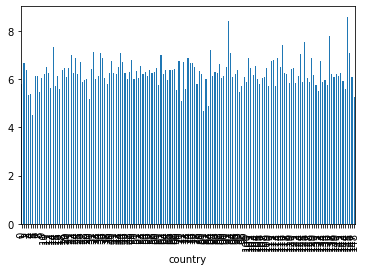

In [25]:
df.groupby('country').rating.mean().plot.bar();

Rating trung bình phim của các nước không cách biệt nhau quá nhiều

# Train Model


In [26]:
select_feature = ['year', 'runtime', 'kind', 'color_info', 'sound_mix','votes',
                  'country', 'day', 'month', 'age', 'number_cast']

In [27]:
X_train = X_train[select_feature]
X_test = X_test[select_feature]

evalset = [(X_train, y_train), (X_test,y_test)]

In [28]:
X_train.kind.value_counts()

1    74313
4      381
7       73
6       10
0        7
3        2
2        2
8        1
5        1
Name: kind, dtype: int64

In [29]:
model = XGBRegressor(n_estimators = 500,
                     max_depth=3);
model.fit(X_train,y_train, eval_metric='rmse', eval_set=evalset);

[0]	validation_0-rmse:3.99905	validation_1-rmse:3.98342
[1]	validation_0-rmse:2.90054	validation_1-rmse:2.88715
[2]	validation_0-rmse:2.16522	validation_1-rmse:2.15518
[3]	validation_0-rmse:1.68989	validation_1-rmse:1.68244
[4]	validation_0-rmse:1.39465	validation_1-rmse:1.39107
[5]	validation_0-rmse:1.22256	validation_1-rmse:1.22250
[6]	validation_0-rmse:1.12617	validation_1-rmse:1.12916
[7]	validation_0-rmse:1.07323	validation_1-rmse:1.07833
[8]	validation_0-rmse:1.04467	validation_1-rmse:1.05096
[9]	validation_0-rmse:1.02904	validation_1-rmse:1.03678
[10]	validation_0-rmse:1.01968	validation_1-rmse:1.02782
[11]	validation_0-rmse:1.01408	validation_1-rmse:1.02299
[12]	validation_0-rmse:1.01026	validation_1-rmse:1.01991
[13]	validation_0-rmse:1.00716	validation_1-rmse:1.01737
[14]	validation_0-rmse:1.00518	validation_1-rmse:1.01577
[15]	validation_0-rmse:1.00314	validation_1-rmse:1.01416
[16]	validation_0-rmse:1.00177	validation_1-rmse:1.01302
[17]	validation_0-rmse:1.00028	validation

[144]	validation_0-rmse:0.95248	validation_1-rmse:0.97532
[145]	validation_0-rmse:0.95232	validation_1-rmse:0.97525
[146]	validation_0-rmse:0.95228	validation_1-rmse:0.97525
[147]	validation_0-rmse:0.95216	validation_1-rmse:0.97525
[148]	validation_0-rmse:0.95194	validation_1-rmse:0.97503
[149]	validation_0-rmse:0.95174	validation_1-rmse:0.97506
[150]	validation_0-rmse:0.95152	validation_1-rmse:0.97495
[151]	validation_0-rmse:0.95146	validation_1-rmse:0.97485
[152]	validation_0-rmse:0.95136	validation_1-rmse:0.97480
[153]	validation_0-rmse:0.95122	validation_1-rmse:0.97483
[154]	validation_0-rmse:0.95106	validation_1-rmse:0.97483
[155]	validation_0-rmse:0.95087	validation_1-rmse:0.97477
[156]	validation_0-rmse:0.95074	validation_1-rmse:0.97472
[157]	validation_0-rmse:0.95059	validation_1-rmse:0.97457
[158]	validation_0-rmse:0.95025	validation_1-rmse:0.97447
[159]	validation_0-rmse:0.95016	validation_1-rmse:0.97444
[160]	validation_0-rmse:0.94935	validation_1-rmse:0.97342
[161]	validati

[286]	validation_0-rmse:0.93425	validation_1-rmse:0.96599
[287]	validation_0-rmse:0.93417	validation_1-rmse:0.96608
[288]	validation_0-rmse:0.93410	validation_1-rmse:0.96603
[289]	validation_0-rmse:0.93390	validation_1-rmse:0.96623
[290]	validation_0-rmse:0.93378	validation_1-rmse:0.96612
[291]	validation_0-rmse:0.93358	validation_1-rmse:0.96594
[292]	validation_0-rmse:0.93348	validation_1-rmse:0.96586
[293]	validation_0-rmse:0.93336	validation_1-rmse:0.96582
[294]	validation_0-rmse:0.93322	validation_1-rmse:0.96576
[295]	validation_0-rmse:0.93315	validation_1-rmse:0.96585
[296]	validation_0-rmse:0.93295	validation_1-rmse:0.96544
[297]	validation_0-rmse:0.93286	validation_1-rmse:0.96547
[298]	validation_0-rmse:0.93281	validation_1-rmse:0.96545
[299]	validation_0-rmse:0.93275	validation_1-rmse:0.96549
[300]	validation_0-rmse:0.93270	validation_1-rmse:0.96547
[301]	validation_0-rmse:0.93265	validation_1-rmse:0.96546
[302]	validation_0-rmse:0.93261	validation_1-rmse:0.96546
[303]	validati

[428]	validation_0-rmse:0.92203	validation_1-rmse:0.96114
[429]	validation_0-rmse:0.92196	validation_1-rmse:0.96118
[430]	validation_0-rmse:0.92187	validation_1-rmse:0.96121
[431]	validation_0-rmse:0.92185	validation_1-rmse:0.96121
[432]	validation_0-rmse:0.92180	validation_1-rmse:0.96114
[433]	validation_0-rmse:0.92178	validation_1-rmse:0.96110
[434]	validation_0-rmse:0.92170	validation_1-rmse:0.96125
[435]	validation_0-rmse:0.92164	validation_1-rmse:0.96121
[436]	validation_0-rmse:0.92154	validation_1-rmse:0.96119
[437]	validation_0-rmse:0.92134	validation_1-rmse:0.96107
[438]	validation_0-rmse:0.92129	validation_1-rmse:0.96108
[439]	validation_0-rmse:0.92122	validation_1-rmse:0.96100
[440]	validation_0-rmse:0.92114	validation_1-rmse:0.96101
[441]	validation_0-rmse:0.92105	validation_1-rmse:0.96092
[442]	validation_0-rmse:0.92100	validation_1-rmse:0.96093
[443]	validation_0-rmse:0.92091	validation_1-rmse:0.96086
[444]	validation_0-rmse:0.92084	validation_1-rmse:0.96091
[445]	validati

# Evaluation


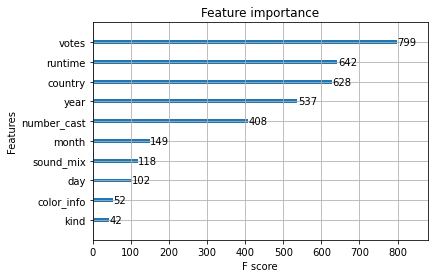

In [30]:
plot_importance(model)
pyplot.show()

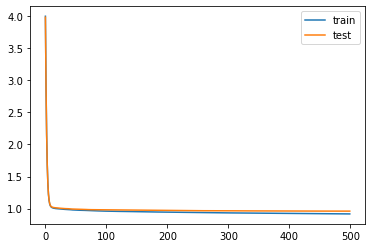

In [31]:
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [34]:
import pickle
file_name = "movie_score_predict.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

In [35]:
model = pickle.load(open(file_name, "rb"))